# PTEN cis effect

This notebook creates a boxplot for the cis effect of PTEN cnv deletions in 8 cancers. These 8 cancers were chosen because they have enough samples with PTEN cnv deletions to do a t-test. Only Ccrcc does not have enough samples with deletions. 

Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import cptac
import cptac.pancan as pc
import cptac.utils as u
import plot_utils as p

In [2]:
print('cptac version:', cptac.version())

cptac version: 0.9.0


Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation type from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [3]:
'''
Params
cancer_object: Object. The loaded cancer data set.
all_prot: List. trans proteins used to get proteomics data. 
gene_in: String. Gene used to get mutation status for the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with trans proteomics and mutation status of a specific gene.
'''

def format_df(cancer_object, all_prot = 'PTEN', gene_in = 'PTEN', utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in, omics_source = 'washu') # washu has cnv
    if cancer_object.get_cancer_type() not in ('pancanluad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(mutations_genes = [gene_in], 
                                            omics_df_name = 'proteomics', omics_source = 'umich', 
                                            omics_genes = all_prot, tissue_type = 'tumor')
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
            prot_and_mutations = rename_duplicate_cols(prot_and_mutations) # add '_i' to distinguish
            
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] # get mutation column (created in get_genotype_all_vars)
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('pancanluad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics', df1_source = 'washu', 
                                                  df2_source = 'umich', genes1= gene_in, genes2= all_prot, 
                                                  tissue_type = 'tumor')
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = rename_duplicate_cols(omics)
        omics = omics.drop(columns='PTEN_washu_CNV')
       
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_umich_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt



In [9]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [10]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac.

In [7]:
en = pc.PancanUcec()
h = pc.PancanHnscc()
l = pc.PancanLuad()
ls = pc.PancanLscc()
o = pc.PancanOv()
r = pc.PancanCcrcc()
co = pc.PancanCoad()
g = pc.PancanGbm()
b = pc.PancanBrca()

/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

# Gbm

In [20]:
gene = 'PTEN'
g_del_wt = format_df(g,gene)
g_del_wt.Mutation.value_counts()
g_del_wt

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 68 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)


Name,PTEN,Mutation
Patient_ID,,
C3L-00104,-0.663853,Deletion
C3L-00365,0.068567,Deletion
C3L-00674,0.206847,Deletion
C3L-00677,-0.804521,Deletion
C3L-01040,0.368882,Deletion
...,...,...
C3N-03183,-0.727954,Deletion
C3N-03184,-0.252810,Deletion
C3N-03186,0.247315,Deletion


In [23]:
g_pval = u.wrap_ttest(g_del_wt, 'Mutation', ['PTEN'], return_all = True)
gp = g_pval.P_Value[0]
g_pval

,Comparison,P_Value
0,PTEN,0.000039


# Luad

In [24]:
l_del_wt = format_df(l, gene)
l_pval = u.wrap_ttest(l_del_wt, 'Mutation', ['PTEN'])
lp = l_pval.P_Value[0]
l_pval

cptac warning: Due to dropping the specified levels, dataframe now has 224 duplicated column headers. (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 285)
cptac warning: washu_CNV data was not found for the following samples, so washu_CNV data columns were filled with NaN for these samples: C3L-01890 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 142)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (<ipython-input-3-1e06404c9b1a>, line 42)
<ipython-input-3-1e06404c9b1a>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_wt['Mutation'] = np.where(


,Comparison,P_Value
0,PTEN,0.0455


# Lscc

In [25]:
ls_del_wt = format_df(ls, gene)
ls_pval = u.wrap_ttest(ls_del_wt, 'Mutation', ['PTEN'])
lsp = ls_pval.P_Value[0]
ls_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)
/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 

,Comparison,P_Value
0,PTEN,0.00014


# Ovarian

In [28]:
'''o_del_wt = format_df(o, gene)
o_pval = u.wrap_ttest(o_del_wt, 'Mutation', ['PTEN'])
op = o_pval.P_Value[0]
o_pval'''

"o_del_wt = format_df(o, gene)\no_pval = u.wrap_ttest(o_del_wt, 'Mutation', ['PTEN'])\nop = o_pval.P_Value[0]\no_pval"

# Brca

In [29]:
b_del_wt = format_df(b, gene)
b_pval = u.wrap_ttest(b_del_wt, 'Mutation', ['PTEN'], return_all = True)
bp = b_pval.P_Value[0]
b_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 114 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)
cptac warning: washu_CNV data was not found for the following samples, so washu_CNV data columns were filled with NaN for these samples: 01BR044, 604 (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 115 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)
cptac warning: umich_proteomics data was not found for the following samples, so umich_proteomics data columns were filled with NaN for these sam

,Comparison,P_Value
0,PTEN,0.212432


# Colon

In [31]:
'''c_del_wt = format_df(col, gene)
c_pval = u.wrap_ttest(c_del_wt, 'Mutation', ['PTEN'])
cp = c_pval.P_Value[0]
c_pval'''

"c_del_wt = format_df(col, gene)\nc_pval = u.wrap_ttest(c_del_wt, 'Mutation', ['PTEN'])\ncp = c_pval.P_Value[0]\nc_pval"

#  Hnscc

In [77]:
h_del_wt = format_df(h, gene)
h_pval = u.wrap_ttest(h_del_wt, 'Mutation', ['PTEN'])
hp = h_pval.P_Value[0]
h_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 107 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)
/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 

,Comparison,P_Value
0,PTEN,7.715471e-09


# Endometrial

The Endometrial data set does not have enough cnv deletions to perform a t-test, however the data set does have enough truncation type mutations (nonsense and frame shifts). Different code is needed to create the data frame for Endometrial.

In [49]:
# Step 1 - Create proteomics and truncations dataframe
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_source='umich',omics_genes = gene, 
    mutations_filter = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']) 
prot_and_mutations = u.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
prot_and_mutations = rename_duplicate_cols(prot_and_mutations) # add '_i' to distinguish
    
keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins','Wildtype_Tumor']
in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
trunc_mutations = prot_and_mutations[in_keep]
print(trunc_mutations['PTEN_Mutation'].value_counts())

# Step 2 - Create binary column 
trunc_mutations['Mutation'] = np.where(
            trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

# Step 3 - Format the dataframe correctly for the t-test(just omics and binary columns for tumors)
tumors = trunc_mutations[trunc_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
e_trunc_wt = tumors.drop(columns_to_drop, axis = 1)
e_trunc_wt = e_trunc_wt.dropna(axis=1,how='all')
e_trunc_wt['Mutation'].value_counts()

e_trunc_wt = e_trunc_wt.rename(columns={col: re.sub(r'_umich_proteomics', '', col) for col in e_trunc_wt.columns.tolist()})

e_pval = u.wrap_ttest(e_trunc_wt, 'Mutation', ['PTEN'], return_all = True)
ep = e_pval.P_Value[0]
e_pval

Wildtype_Tumor       28
Nonsense_Mutation    24
Frame_Shift_Del      21
Frame_Shift_Ins       6
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 59 samples for the PTEN gene (/Users/brittanyhenderson/anaconda3/lib/python3.8/site-packages/cptac/pancan/pancandataset.py, line 168)
<ipython-input-49-77f8beb74020>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trunc_mutations['Mutation'] = np.where(


,Comparison,P_Value
0,PTEN,0.000005


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Proteomics, Mutation, and Cancer. We need to append all the individual cancer dfs into one long pancancer df. 

First create the Cancer column.

In [78]:
g_del_wt = g_del_wt.assign(cancer = 'GBM')
l_del_wt = l_del_wt.assign(cancer = 'LUAD')
ls_del_wt = ls_del_wt.assign(cancer = 'LSCC')
b_del_wt = b_del_wt.assign(cancer = 'BR')
#o_del_wt = o_del_wt.assign(cancer = 'OV')
#c_del_wt = c_del_wt.assign(cancer = 'CO')
h_del_wt = h_del_wt.assign(cancer = 'HNSCC') # higher scale
e_trunc_wt = e_trunc_wt.assign(cancer = 'EC')

Next append the dfs.

In [84]:
df = g_del_wt.append(l_del_wt)
df2 = df.append(ls_del_wt)
df3 = df2.append(b_del_wt)
#df4 = df3.append(o_del_wt)
#df5 = df4.append(c_del_wt)
df6 = df3.append(h_del_wt)
df7 = df6.append(e_trunc_wt) 

df7 = df7.rename(columns={'PTEN':'PTEN Proteomics (Umich)'})
df7

Name,PTEN Proteomics (Umich),Mutation,cancer
Patient_ID,,,
C3L-00104,-0.663853,Deletion,GBM
C3L-00365,0.068567,Deletion,GBM
C3L-00674,0.206847,Deletion,GBM
C3L-00677,-0.804521,Deletion,GBM
C3L-01040,0.368882,Deletion,GBM
...,...,...,...
C3N-01520,-1.119450,Truncation,EC
C3N-01521,-0.216100,Wildtype_Tumor,EC
C3N-01537,-0.172155,Wildtype_Tumor,EC


# Step 3: Create the Pancancer Boxplot

p-values: 

GBM 3.926002547232086e-05 

HNSCC 7.715471423929107e-09 

BR 0.21243174305911555 

LSCC 0.0001402228820994241 

LUAD 0.04550016242971832 

EC 4.796434471177064e-06 



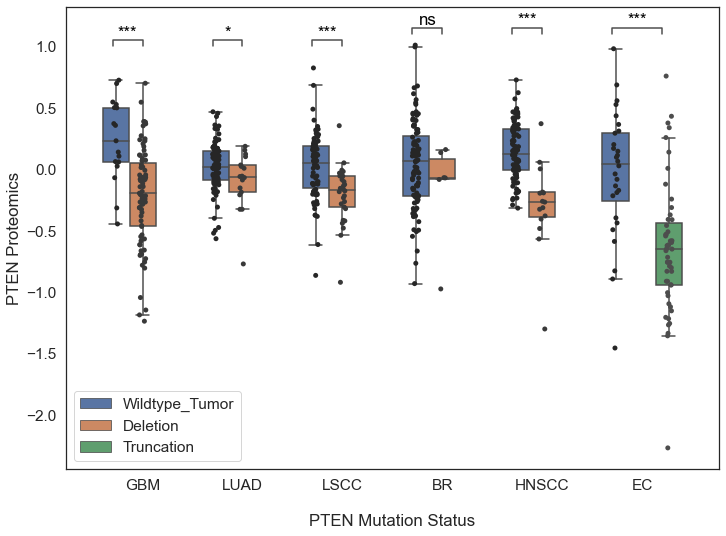

In [86]:
# cis plot
gene = 'PTEN'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4, style = 'white')

boxplot = sns.boxplot(x='cancer', y='PTEN Proteomics (Umich)', data = df7, hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Deletion",'Truncation'], showfliers = False)    
#boxplot.set_title('Pancancer cis effect of PTEN CNV Deletions')
boxplot = sns.stripplot(x='cancer', y='PTEN Proteomics (Umich)', data = df7, jitter = True, 
                           color = ".3", hue = 'Mutation', hue_order = ["Wildtype_Tumor", "Deletion", 'Truncation'], dodge = True)
boxplot.set(xlabel = "\nPTEN Mutation Status", ylabel = gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# Create significance symbols:
# * P < 0.015   ** P < 0.001   *** P < 0.0001 
cancer_pvals = {'GBM':gp, 'HNSCC':hp, 'BR':bp, 'LSCC':lsp, 'LUAD':lp, 'EC':ep}

# create pval annotations
symbols = {}
print('p-values: \n')
for cancer in cancer_pvals:
    val = str(cancer_pvals[cancer])
    if cancer_pvals[cancer]  < 0.001:
        symbols[cancer] = '***'
    elif cancer_pvals[cancer]  < 0.01:
        symbols[cancer] = '**'  
    elif cancer_pvals[cancer]  < 0.05:
        symbols[cancer] = '*'
    else:
        symbols[cancer] = 'ns'
    print(cancer, val, '\n')
        

format_pval_annotation(symbols['GBM'], -.3, 0, 1) 
format_pval_annotation(symbols['LUAD'], .7, 1, 1) 
format_pval_annotation(symbols['LSCC'], 1.7, 2, 1) # Lscc
format_pval_annotation(symbols['BR'], 2.7, 3, 1.1) # Brca
#format_pval_annotation(symbols['OV'], 3.7, 4, 1.6) # Ovarian
#format_pval_annotation(symbols['CO'], 4.7, 5, 1)  # Colon
format_pval_annotation(symbols['EC'], 3.7, 4, 1.1) # Endometrial
format_pval_annotation(symbols['HNSCC'], 4.7, 5.2, 1.1) # HNSCC

plt.show()
plt.clf()
plt.close()

In [87]:
symbols

{'GBM': '***',
 'HNSCC': '***',
 'BR': 'ns',
 'LSCC': '***',
 'LUAD': '*',
 'EC': '***'}

In [88]:
# Save figure
fig = boxplot.get_figure()
fig.savefig("Sup_Fig_4A.png", dpi = 300)